# 05 — Ridge regularization (stability)

## Objective
Introduce Ridge regularization to improve coefficient stability under
multicollinearity and sparse channels, using the adstock + saturation features.

## Inputs
- Weekly target `y`
- Features: adstock + saturation (baseline theta, baseline alpha, k by channel)

## Output
- Ridge models across a grid of alphas (regularization strength)
- Coefficient stability analysis
- A defensible baseline regularization choice


## Why Ridge

### Context
MMM features are often correlated (e.g., channels move together over time).
This multicollinearity makes ordinary least squares (OLS) coefficients unstable.

### Decision
Use Ridge regression as the baseline regularized estimator.

### Rationale
Ridge shrinks coefficients smoothly, improving stability and reducing sensitivity
to correlated inputs while keeping all channels in the model.


In [10]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error


In [11]:
target_col = "ALL_PURCHASES"
date_col = "DATE_DAY"

In [12]:
X_sat = pd.read_csv("../data/processed/mmm_dataset_weekly_saturation.csv")
y = pd.read_csv("../data/processed/mmm_dataset_weekly_y_column.csv")


In [13]:

X = X_sat.copy()              # from notebook 04
y_1d = np.asarray(y).ravel()  # ensure 1D

X.shape, y_1d.shape


((251, 9), (251,))

## Feature scaling

Ridge regression is sensitive to feature scale.
We standardize features so the penalty shrinks coefficients fairly across channels.

Implementation:
- StandardScaler on X
- Ridge on standardized features


In [14]:
alphas = np.logspace(-3, 3, 13)  # 1e-3 ... 1e3
rows = []
coefs = []

for a in alphas:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=a))
    ])
    pipe.fit(X, y_1d)
    pred = pipe.predict(X)

    rows.append({
        "ridge_alpha": a,
        "r2": r2_score(y_1d, pred),
        "mae": mean_absolute_error(y_1d, pred)
    })

    coef = pipe.named_steps["ridge"].coef_
    coefs.append(pd.Series(coef, index=X.columns, name=a))

metrics_ridge = pd.DataFrame(rows)
coef_ridge = pd.DataFrame(coefs)



In [15]:

metrics_ridge.head()

,ridge_alpha,r2,mae
0,0.001000,0.564483,32.124805
1,0.003162,0.564483,32.124886
2,0.010000,0.564483,32.125142
3,0.031623,0.564483,32.125953
4,0.100000,0.564481,32.128511


In [16]:
coef_ridge.head()

,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND
0.001000,10.547669,45.199645,75.365595,-5.923775,0.0,0.0,0.0,0.0,0.0
0.003162,10.546887,45.196737,75.361681,-5.924581,0.0,0.0,0.0,0.0,0.0
0.010000,10.544413,45.187543,75.349306,-5.927126,0.0,0.0,0.0,0.0,0.0
0.031623,10.536597,45.158492,75.310203,-5.935166,0.0,0.0,0.0,0.0,0.0
0.100000,10.511928,45.066854,75.186847,-5.960513,0.0,0.0,0.0,0.0,0.0


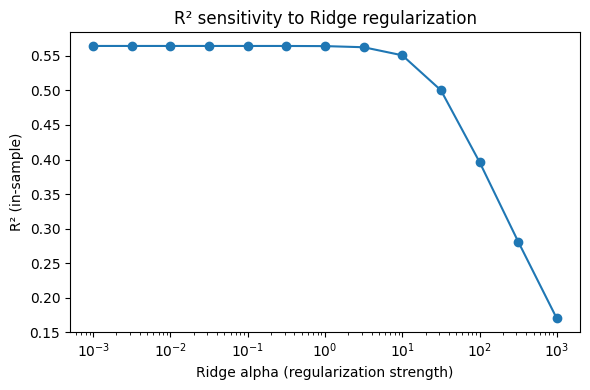

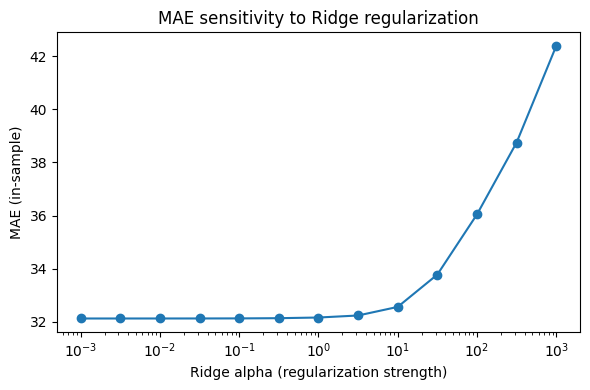

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.semilogx(metrics_ridge["ridge_alpha"], metrics_ridge["r2"], marker="o")
plt.xlabel("Ridge alpha (regularization strength)")
plt.ylabel("R² (in-sample)")
plt.title("R² sensitivity to Ridge regularization")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.semilogx(metrics_ridge["ridge_alpha"], metrics_ridge["mae"], marker="o")
plt.xlabel("Ridge alpha (regularization strength)")
plt.ylabel("MAE (in-sample)")
plt.title("MAE sensitivity to Ridge regularization")
plt.tight_layout()
plt.show()


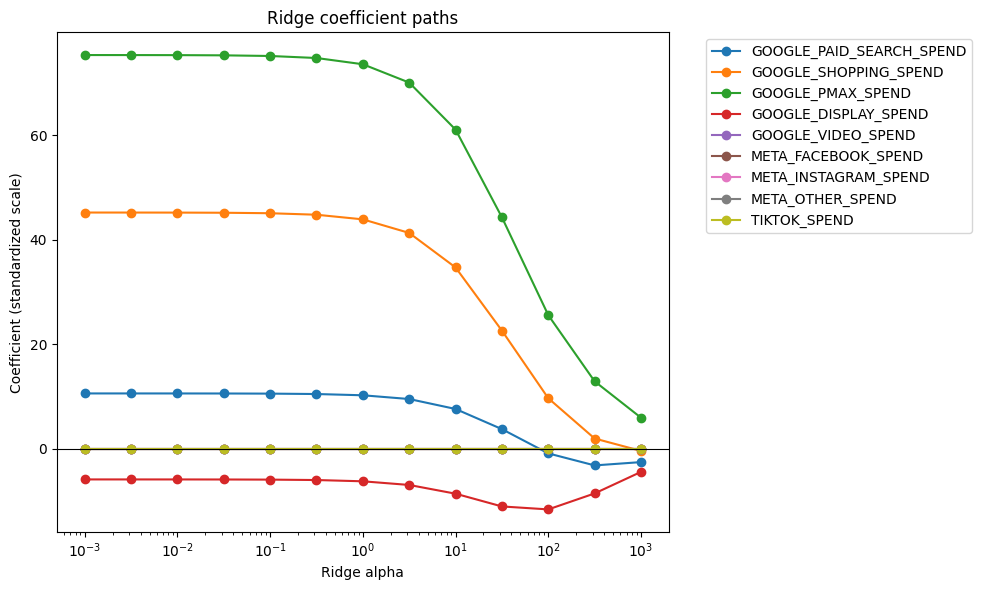

In [18]:
coef_long = (
    coef_ridge
    .reset_index(drop=False)
    .rename(columns={"index": "ridge_alpha"})
    .melt(id_vars="ridge_alpha", var_name="channel", value_name="coef")
)

plt.figure(figsize=(10, 6))
for ch in coef_long["channel"].unique():
    sub = coef_long[coef_long["channel"] == ch]
    plt.semilogx(sub["ridge_alpha"], sub["coef"], marker="o", label=ch)

plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Ridge alpha")
plt.ylabel("Coefficient (standardized scale)")
plt.title("Ridge coefficient paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Choosing ridge_alpha

We prefer a regularization strength that:
- stabilizes coefficient paths (smooth, non-explosive)
- avoids excessive shrinkage (all coefficients ~0)
- preserves interpretability and plausible signs

The goal is not maximizing R², but improving robustness and stability.


## Decision

Select a moderate level of Ridge regularization:
- **Baseline ridge_alpha: 1.0**

## Rationale

Ridge alpha = 1.0 lies within a flat region of the fit curve where:
- in-sample R² and MAE remain stable
- coefficient paths are smooth and well-behaved
- strong channels retain signal while weak channels are appropriately shrunk

Higher regularization values lead to excessive shrinkage and loss of signal,
while lower values provide limited protection against multicollinearity.

This choice prioritizes coefficient stability and interpretability over
maximizing in-sample fit.
